# Mini-projet n°1 - Chats ou Chiens ?

Dans ce projet, nous allons étudier, classifier et segmenter les images du jeu de données Oxford-IIIT Pet Dataset. Ce jeu de données comporte des images de chats et chiens de 37 races différentes.

In [228]:
# Utils
import os
#import shutil
#import time

In [70]:
# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

In [71]:
# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [72]:
# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

## Chargement des données

In [264]:
list = "./annotations//list.txt"
image_dir = "./images"

# Chargement des images du dataset
images = [f for f in os.listdir(image_dir) if f.lower().endswith("jpg")]
print("Il y a ", len(images), "images dans le dataset.")

# Chargement des informations (label) des images, avec le fichier list.txt
df = pd.read_csv(
    list,
    sep=r'\s+',          
    comment='#',         
    header=None,         
    usecols=[0, 1, 2], 
    names=['image', # nom de l'image (sans extension)
           'class_id', # identifiant de la classe (race), entre 1 et 37
           'type'] # type d'animal : 1=chat, 2=chien
)
df["image"] = df["image"].apply(lambda x: x + ".jpg")
n_total = len(df)
print(f"Il y a {n_total} images référencées dans list.txt.")

# Vérification du référencement des images
missing_list = sorted(set(images) - set(df["image"])) # images dans le dataset sans entrée dans list.txt
missing_images = sorted(set(df["image"]) - set(images)) # images référencées dans list.txt mais manquantes dans le dataset
print(f"Il y a {len(missing_list)} images dans le dataset sans entrée dans list.txt.")
print(f"Il y a {len(missing_images)} images référencées dans list.txt mais manquantes dans le dataset.")  

pd.set_option('display.max_rows', None)    # affiche toutes les lignes
pd.set_option('display.max_columns', None) # affiche toutes les colonnes
pd.set_option('display.width', None)       # pas de coupure de lignes
pd.set_option('display.max_colwidth', None) # montre le texte entier dans chaque cellule

Il y a  7390 images dans le dataset.
Il y a 7349 images référencées dans list.txt.
Il y a 41 images dans le dataset sans entrée dans list.txt.
Il y a 0 images référencées dans list.txt mais manquantes dans le dataset.


Certaines images existent dans le dossier "images", mais n'ont pas d'entrées dans list.txt. On va donc les faire rentrer dans le jeu de données, en mettant comme identifiant de classe et type la même chose que les autres fichiers commençant par le même nom.

In [265]:
def get_prefix(filename):
    return filename.split('_')[0]

# Ajout d'informations dans le DataFrame
df["class"] = df["image"].apply(get_prefix)
df["animal"] = df["type"].apply(lambda x: "cat" if x == 1 else "dog")

# Création d'un dictionnaire de classes connues
classes = (
    df.groupby("class")[["class_id", "type"]]
      .first()
      .to_dict(orient="index")
)

# Ajout du référencement des images dans le DataFrame
new_rows = []
for img in missing_list :
    class_name = get_prefix(img)
    if class_name in classes: # Si on ne connait pas, on ne rajoute pas au DataFrame
        class_id = classes[class_name]["class_id"]
        type = classes[class_name]["type"]
        new_rows.append({
            "image": os.path.splitext(img)[0],
            "class_id": class_id,
            "type": type,
            "class": class_name,
            "animal": "cat" if type == 1 else "dog"
        })

print(f"{len(new_rows)} nouvelles lignes créées.")
df_new = pd.DataFrame(new_rows)
df_full = pd.concat([df, df_new], ignore_index=True)
df_full["image"] = df_full["image"].apply(
    lambda x: x + ".jpg" if not x.lower().endswith(".jpg") else x
)

missing_images = sorted(set(images) - set(df_full["image"]))
print(f"Il y a maintenant {len(missing_images)} images du dataset qui ne sont pas référencées dans le DataFrame.")


df_full.head()

41 nouvelles lignes créées.
Il y a maintenant 0 images du dataset qui ne sont pas référencées dans le DataFrame.


,image,class_id,type,class,animal
0,Abyssinian_100.jpg,1,1,Abyssinian,cat
1,Abyssinian_101.jpg,1,1,Abyssinian,cat
2,Abyssinian_102.jpg,1,1,Abyssinian,cat
3,Abyssinian_103.jpg,1,1,Abyssinian,cat
4,Abyssinian_104.jpg,1,1,Abyssinian,cat


In [266]:
# Nettoyage 
del(df)
df = df_full
del(new_rows)
del(df_new)
del(df_full)

## Analyse exploratoire

### Etude de la répartition par race et par type

In [267]:
df["class"] = df["class"].astype("category")
df["animal"] = df["animal"].astype("category")
df.dtypes

image         object
class_id       int64
type           int64
class       category
animal      category
dtype: object

In [268]:
nb_images = len(df)
n_class = df["class"].nunique()
n_class_cat = df[df["animal"] == "cat"]["class"].nunique()
n_class_dog = df[df["animal"] == "dog"]["class"].nunique()
nb_cat = len(df[df["animal"] == "cat"])
nb_dog = len(df[df["animal"] == "dog"])

print(f"Il y a {n_class} races différentes dans le dataset, pour {nb_images} images.")
print(f"Il y a {n_class_cat} races de chats et {n_class_dog} races de chiens.")
print(f"Cela représente {nb_cat} images de chats et {nb_dog} images de chiens.")


Il y a 35 races différentes dans le dataset, pour 7390 images.
Il y a 12 races de chats et 23 races de chiens.
Cela représente 2400 images de chats et 4990 images de chiens.


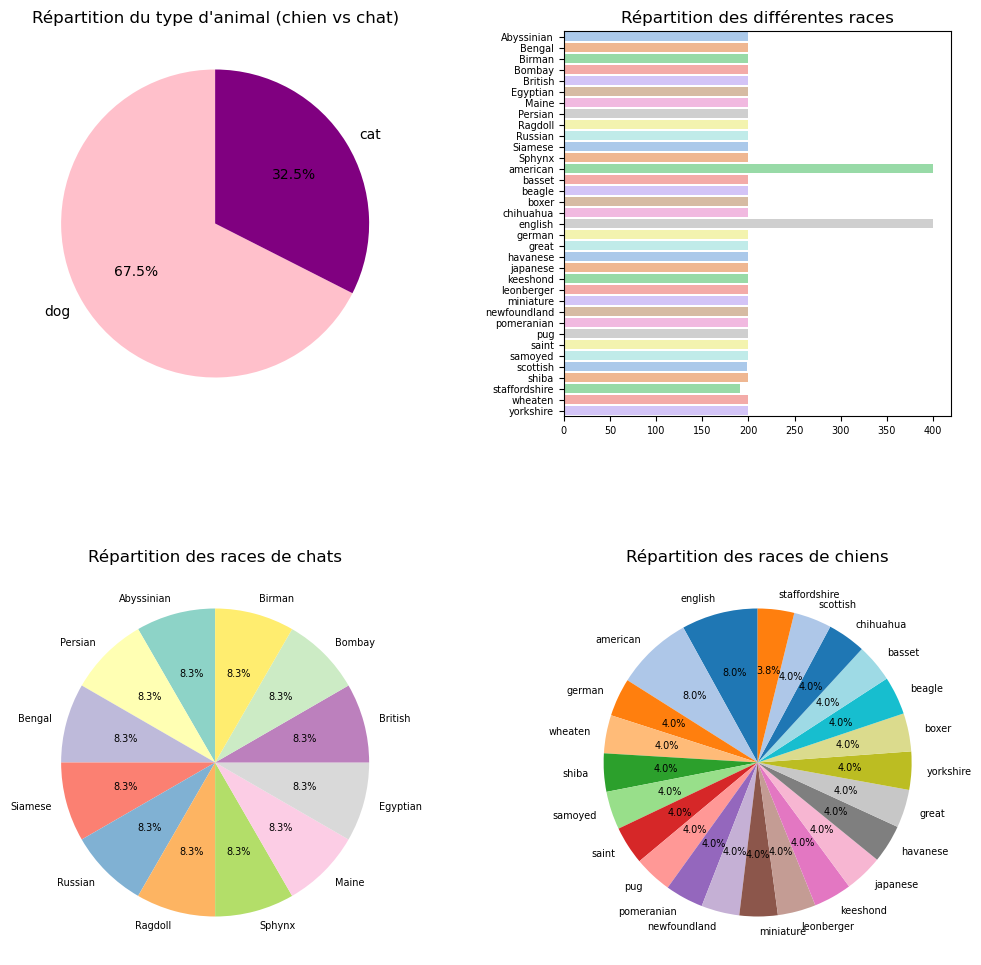

In [269]:
# Nombre d’images par type d'animal : chien vs chat
counts_1 = df["animal"].value_counts()

# Nombre d’images par race
counts_2 = df["class"].value_counts()

# Parmi les chats, répartition des races
counts_3 = df[df["animal"] == "cat"]["class"].value_counts()
counts_3 = counts_3[counts_3 > 0]
labels_cats =  [c for c in counts_3.index if counts_3[c] > 0]
palette_cat = sns.color_palette("Set3", n_colors=len(counts_3))

# Parmi les chiens, répartition des races
counts_4 = df[df["animal"] == "dog"]["class"].value_counts()
counts_4 = counts_4[counts_4 > 0]
labels_dogs =  [c for c in counts_4.index if counts_4[c] > 0]
palette_dog = sns.color_palette("tab20", n_colors=len(counts_4))

# Affichage des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

axes[0,0].pie(counts_1, labels=counts_1.index, autopct='%1.1f%%', startangle=90, colors=["pink", "purple"])
axes[0,0].set_title("Répartition du type d'animal (chien vs chat)")

sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])
axes[0,1].set_title("Répartition des différentes races")
axes[0,1].tick_params(axis='x', labelsize=7)
axes[0,1].tick_params(axis='y', labelsize=7) 

axes[1,0].pie(counts_3, labels=labels_cats, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_cat)
axes[1,0].set_title("Répartition des races de chats")

axes[1,1].pie(x=counts_4,  labels=counts_4.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_dog)
axes[1,1].set_title("Répartition des races de chiens")

plt.tight_layout
fig.subplots_adjust(hspace=0.4, wspace=0.4)  

plt.show()


Dans ce dataset, il y a beaucoup plus de chiens (67.5%) que de chats (32.5%). Malgré tout, les différentes races sont dans l'ensemble bien réparties puisqu'il y a 200 images pour chaque race, à l'exception des races "american" et "english", qui comportent 400 individus chacune. La race "staffordshire" comporte quant à elle un tout petit peu moins de 200 individus. Lorsque l'on regarde la répartion des 12 races de chats parmis les chats, elles sont parfaitement équilibrées. Pour la répartition des 27 races de chien, on avait effectivement remarqué que 2 étaient plus représentées les autres. Le reste est néanmoins équilibré. 

### Vérification de la cohérence et la qualité des masques de segmentation

Un masque de segmentation est un masque de la même taille que l'image, qui va nous permettre d'avoir l'information du sujet de l'image. En effet, le masque va donner à chaque pixel de l'image une valeur parmi ces trois : 
- 1 si le pixel appartient au premier plan de l'image, soit l'animal dans notre cas 
- 2 si le pixel appartient à l'arrière-plan de l'image 
- 3 si le pixel n'est pas classifié.

Les masques de segmentation se trouvent dans le dossier *annotations/trimaps*. Nous allons donc regarder sur un petit jeu de données, sélectionné aléatoirement parmi notre dataset ce que donne le masque de segmentation. 


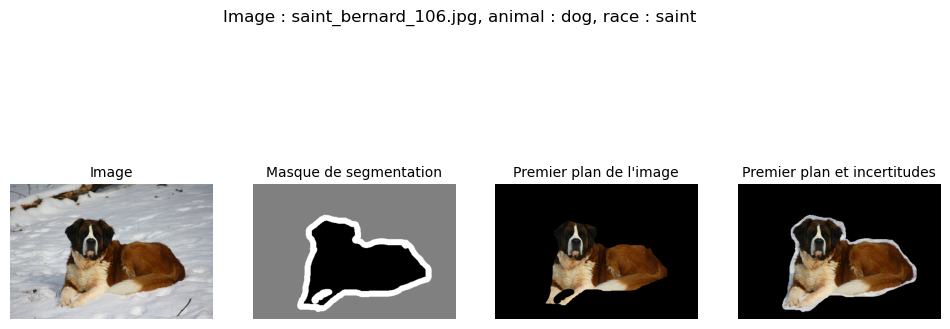

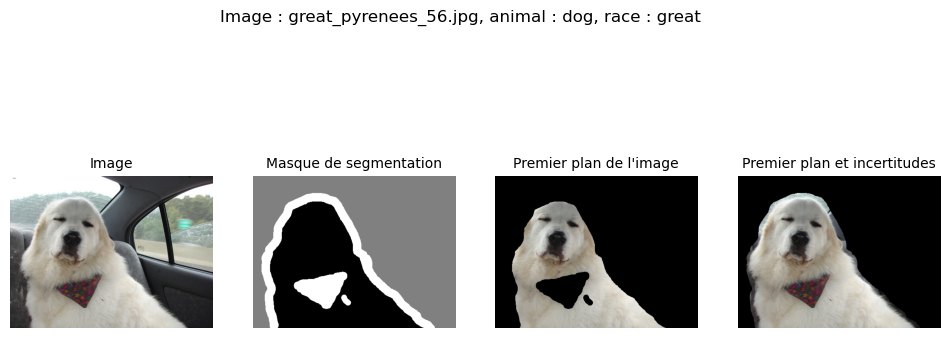

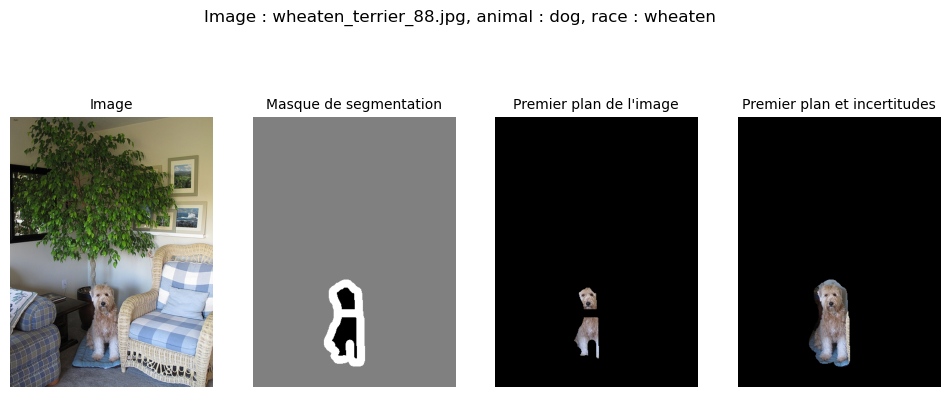

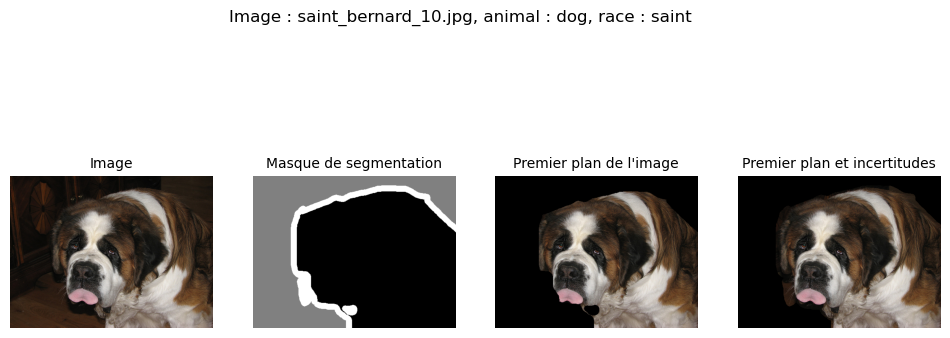

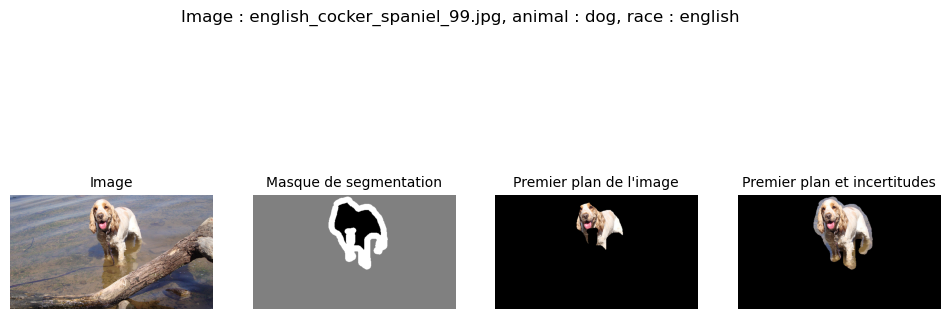

In [278]:
from PIL import Image 

path_images = "./images/"
path_masks = "./annotations/trimaps/"

n = 5

for i in range(5): 
    # Sélection aléatoire d'une image
    filename = rd.choice(df['image'])

    # Chargement de l'image et du masque
    img = np.array(Image.open(path_images + filename))
    mask = np.array(Image.open(path_masks + filename.replace('.jpg', '.png')))

    # Image avec le masque appliqué (seulement le corps de l'animal)
    img_foreground = img.copy()
    img_foreground[mask != 1] = 0  

    # Image avec le masque appliqué (corps de l'animal + zone d'incertitude)
    img_background = img.copy()
    img_background[mask == 2] = 0

    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"Image : {filename}, animal : {df[df['image'] == filename]['animal'].values[0]}, race : {df[df['image'] == filename]['class'].values[0]}")

    axes[0].imshow(img)
    axes[0].set_title("Image", fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Masque de segmentation", fontsize=10)
    axes[1].axis("off")

    axes[2].imshow(img_foreground)  
    axes[2].set_title("Premier plan de l'image", fontsize=10)
    axes[2].axis("off")

    axes[3].imshow(img_background)
    axes[3].set_title("Premier plan et incertitudes", fontsize=10)
    axes[3].axis("off")

    plt.show()

Cela nous permet de vérifier que les masques sont cohérents avec l'image. Cependant, pour certaines photos, la zone d'incertitude peut être assez grande. C'est notamment le cas lorsque l'animal est de la même couleur que l'arrière plan, qu'il est caché par un objet, qu'il a des moustaches ou un collier. 

## Classification binaire

## Classification fine

## Analyse Comparative